In [ ]:
import numpy as np
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
import random


PI = np.pi
LAMBDA = 0.2
L = 32
ITER = 10000 # number of trials
SIG = 0.1**0.5 # variance of noise


# Generating F
F = np.zeros((512,L), dtype=np.cdouble)
for i in range(512):
    for j in range(L):
        tmp = (2*PI*i*j)/512
        F[i][j] = np.exp(1j*tmp)

In [ ]:
# Utility Functions

def pinv(A, alpha=0): 
    Ah = np.asmatrix(A).getH()
    return  np.matmul(inv(np.matmul(Ah,A)+alpha*np.eye(A.shape[1])),Ah)

def Genh(L=32,a_var=0.5,b_var=0.5,lda=LAMBDA,sparse=False,sploc=0):
    
    p = np.array([np.exp(-lda*(k)) for k in range(L)])
    a = np.random.normal(0, np.sqrt(a_var), (L))
    b = np.random.normal(0, np.sqrt(b_var), (L))
    
    h=np.zeros((L),dtype=np.cdouble)
    
    if(not sparse):
        h = (p*(a+(1j*b)))/norm(p)
    else:
        for i in sploc:
            h[i]=(p[i]*(a[i]+(1j*b[i])))/norm(p)
    return(h)        
        
def GenX(gaurd=0,dim=512):
    X = np.zeros((dim,dim), dtype=np.cdouble)
    d = {0:1+1j, 1:1-1j, 2:-1+1j, 3:-1-1j}
    x = np.random.randint(4, size=dim)
    for i in range(gaurd,512-gaurd):
        X[i][i] = d[x[i]]
    return X
    
def Genn(dim=512,var=0.1):
    n = np.random.normal(0, np.sqrt(var), (dim,2)).view(np.complex128)
    return n[:,0]


def herm(A):
    n=A.conjugate()
    return n.transpose()


def MM(A,B):
    return np.matmul(A,B)


def findsparse(y,A,k0=6):
    s=list()
    r=np.zeros((k0+1,len(y)),dtype=np.cdouble)
    r[0]=y
    max=0
    for k in range(k0):
        for j in range(A.shape[1]):
            if(norm(MM(herm(A[:,j]),r[k]))>norm(MM(herm(A[:,max]),r[k]))):
                max=j
        s.append(max)
        As=A[:,s]
        r[k+1]=MM(np.eye(len(y))-MM(As,pinv(As)),y)
        max=0
    return s

def ploth(h, hcap, ptitle):
    Xaxis=np.arange(0,32)
    plt.figure()
    plt.title(ptitle)
    plt.stem(Xaxis,np.abs(h),linefmt='k', markerfmt='D',label="h", use_line_collection=True)
    plt.stem(Xaxis,np.abs(hcap),linefmt='r', markerfmt='o',label="hcap", use_line_collection=True)
    plt.legend(loc='upper right')
    plt.show()

def MSE_calc(h, h_hat):
    return norm(h-h_hat)**2

def MSE_theo(H, alpha=0, var=0.1):
    D=pinv(H, alpha=alpha); a = 0
    magic=MM(D, herm(D))*var*2
    for i in range(magic.shape[0]):
        #a+=abs(magic[i,i])
        a+=abs(np.linalg.eig(magic)[0][i])
    return a


Theoritical MSE : 0.006250000000000993
Calculated MSE : 0.006238226799396151


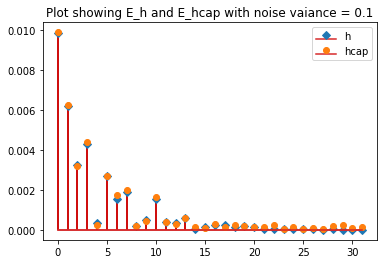

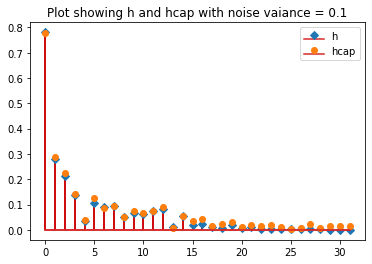

Theoritical MSE : 0.0006250000000000891
Calculated MSE : 0.00062675183394341


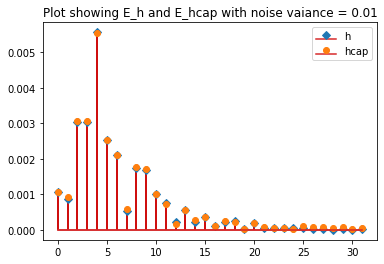

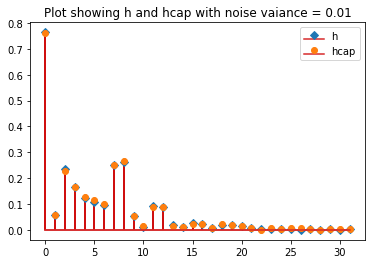

In [ ]:
# Problem 1

def problem1(nvar=0.01, xgaurd=0, ralpha=0, q1=False):
    E_h = np.zeros((32,1))
    E_hcap = np.zeros((32,1))
    mse_calc = 0; mse_theo = 0
    for _  in range(ITER):
        h=Genh()
        x=GenX(gaurd=xgaurd)
        n=Genn(var=nvar)
        XF=np.matmul(x,F)
        y=(np.matmul(XF,h) + n).reshape(-1,1)
        hcap=np.matmul(pinv(XF, alpha=ralpha),y).reshape(32,1)
        E_h = E_h + h.reshape(32,1)
        E_hcap = E_hcap + hcap
        mse_calc += MSE_calc(h.reshape(32,1),hcap)
        mse_theo += MSE_theo(XF, alpha=ralpha, var=nvar)

    mse_calc = mse_calc/ITER
    mse_theo = mse_theo/ITER
    E_h = E_h/ITER
    E_hcap = E_hcap/ITER

    print("Theoritical MSE :",mse_theo)
    print("Calculated MSE :",mse_calc)
    ploth(E_h, E_hcap, "Plot showing E_h and E_hcap with noise vaiance = "+str(nvar))
    if(q1): ploth(h, hcap, "Plot showing h and hcap with noise vaiance = "+str(nvar))

problem1(nvar = 0.1, q1 = True)
problem1(nvar = 0.01, q1 = True)

Theoritical MSE : 0.0011718750000001862
Calculated MSE : 0.001166551334053181


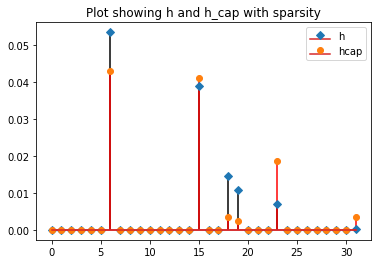

Theoritical MSE : 0.00011718750000001672
Calculated MSE : 0.00011647744341232044


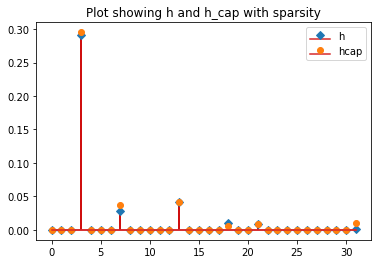

In [ ]:
# Problem 2

def problem2(nvar=0.1, xgaurd=0, ralpha=0):
    
    mse_calc = 0; mse_theo = 0
    for _ in range(ITER):
        sparseloc=random.sample(range(32),6)     
        A=np.zeros((32-len(sparseloc),L))
        j=0
        for i in range(L):
            if(not i in sparseloc):
                A[j][i]=1
                j=j+1   
        x=GenX(gaurd=xgaurd)
        h=Genh(sparse=True,sploc=sparseloc)
        n=Genn(var = nvar)
        XF=np.matmul(x,F)
        y = (np.matmul(XF,h) + n).reshape(-1,1)
        hc= MM(pinv(XF, alpha=ralpha),y).reshape(32,1) 
        hthi=inv(np.matmul(np.asmatrix(XF).getH(),XF) + ralpha*np.eye(XF.shape[1]))
        hcap=hc-np.matmul(np.matmul(np.matmul(hthi,np.transpose(A)),inv(np.matmul(np.matmul(A,hthi),np.transpose(A)))),np.matmul(A,hc))
        mse_calc += MSE_calc(h.reshape(32,1), hcap.reshape(32,1))
        mse_theo += MSE_theo(XF, alpha=ralpha, var=nvar)

    mse_calc = mse_calc/ITER
    mse_theo = mse_theo/ITER
    print("Theoritical MSE :",mse_theo*6/32)
    print("Calculated MSE :",mse_calc)
    ploth(h, hcap, "Plot showing h and h_cap with sparsity")

problem2(nvar=0.1)
problem2(nvar=0.01)

Theoritical MSE : 2.017227689540882e+16
Calculated MSE : 1.0035300533089892e+19


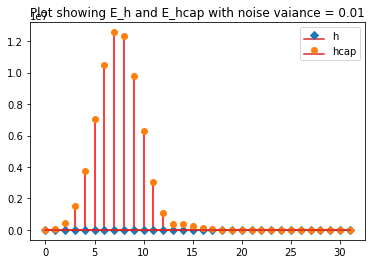

Theoritical MSE : 3894287895315750.0
Calculated MSE : 3.2890425651930783e+18


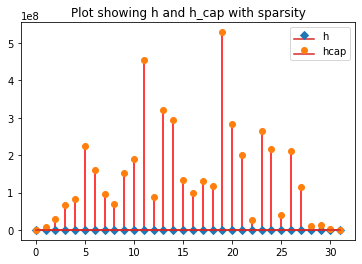

In [ ]:
# Problem 3 - (a)
problem1(nvar=0.01, xgaurd=180)
problem2(nvar=0.01, xgaurd=180)

Theoritical MSE : 0.019648272413215477
Calculated MSE : 0.457129547174851


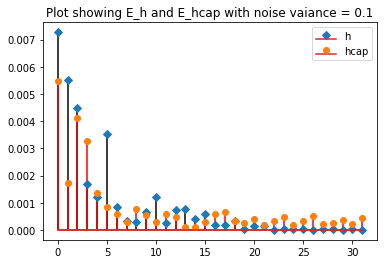

Theoritical MSE : 0.003684051077477902
Calculated MSE : 0.010351317837871006


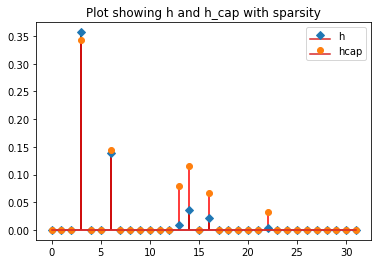

In [ ]:
# Problem 3 - (b)
problem1(nvar=0.1, xgaurd=180, ralpha=5)
problem2(nvar=0.1, xgaurd=180, ralpha=5)

Theoritical MSE : 0.006250000000000993
Calculated MSE : 0.005659283703530634


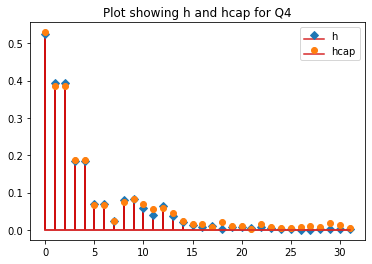

In [ ]:
# Problem 4

A=np.zeros((3,L))
A[0][1]=1
A[0][2]=-1
A[1][3]=1
A[1][4]=-1
A[2][5]=1
A[2][6]=-1

def problem4(nvar = 0.1):
    mse_calc = 0; mse_theo = 0;
    for _ in range(ITER):
        x=GenX()
        h=Genh()
        h[1]=h[2]
        h[3]=h[4]
        h[5]=h[6]
        n=Genn(var=nvar)

        XF=np.matmul(x,F)
        y=(np.matmul(XF,h) + n).reshape(-1,1)
        hc= np.matmul(pinv(XF),y).reshape(32,1) 
        hthi=inv(np.matmul(np.asmatrix(XF).getH(),XF))
        hcap=hc-np.matmul(np.matmul(np.matmul(hthi,np.transpose(A)),inv(np.matmul(np.matmul(A,hthi),np.transpose(A)))),np.matmul(A,hc))

        mse_calc += MSE_calc(h.reshape(32,1), hcap.reshape(32,1))
        mse_theo += MSE_theo(XF, var=nvar)

    mse_calc = mse_calc/ITER
    mse_theo = mse_theo/ITER
    print("Theoritical MSE :",mse_theo)
    print("Calculated MSE :",mse_calc)

    ploth(h, hcap, "Plot showing h and hcap for Q4")

problem4()

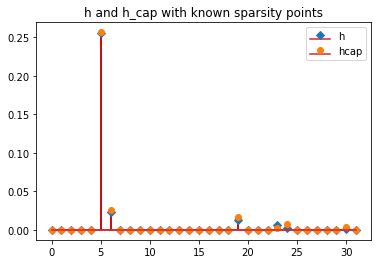

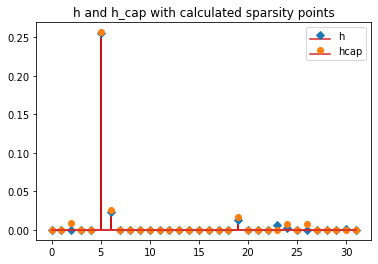

[5, 6, 19, 2, 26, 24] [23, 30, 6, 24, 19, 5]


In [ ]:
# Problem 5

ralpha = 0
sparseloc=random.sample(range(32),6)   
A=np.zeros((32-len(sparseloc),L)); j=0
for i in range(L):
    if(not i in sparseloc):
        A[j][i]=1
        j=j+1   

x=GenX(gaurd=0)
h=Genh(sparse=True,sploc=sparseloc)
n=Genn(var=0.01)
XF=np.matmul(x,F)
y = (np.matmul(XF,h) + n).reshape(-1,1)
hc= MM(pinv(XF, alpha=ralpha),y).reshape(32,1) 
hthi=inv(np.matmul(np.asmatrix(XF).getH(),XF) + ralpha*np.eye(XF.shape[1]))

hcap=hc-np.matmul(np.matmul(np.matmul(hthi,np.transpose(A)),inv(np.matmul(np.matmul(A,hthi),np.transpose(A)))),np.matmul(A,hc))
ploth(h,hcap, "h and h_cap with known sparsity points")

sparse_calc = findsparse(y.reshape(512), XF, 6)
A=np.zeros((32-len(sparse_calc),L)); j=0
for i in range(L):
    if(not i in sparse_calc):
        A[j][i]=1
        j=j+1
hcap=hc-np.matmul(np.matmul(np.matmul(hthi,np.transpose(A)),inv(np.matmul(np.matmul(A,hthi),np.transpose(A)))),np.matmul(A,hc))
ploth(h,hcap, "h and h_cap with calculated sparsity points")

print(sparse_calc, sparseloc)